In [1]:
pip install missingno xgboost

Note: you may need to restart the kernel to use updated packages.


# Desafío Spike
## 1. Datos: Precipitaciones, Indicadores Económicos Banco Central
Como primer paso se cargan los datos de los archivos precipitaciones.csv y banco_central.csv como los DataFrames 'precip' y 'banco' respectivamente, aparte de importar también los modulos a utilizar.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import copy
import xgboost as xgb
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

precip = pd.read_csv("precipitaciones.csv")
banco = pd.read_csv("banco_central.csv")

## 2. Análisis de datos. Creación de variables
### 2.1 Precipitaciones
Los datos corresponden a precipitaciones mensuales en 8 regiones de chile desde 1979 hasta 2020. 


In [3]:
precip.head()

,date,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios
0,1989-02-01,0.719033,0.117045,0.028272,0.0,0.724667,9.172945,22.595834,52.268010
1,1998-10-01,0.065216,0.000000,0.011493,0.0,0.008968,2.089674,14.702087,45.142041
2,2001-02-01,2.030026,0.047987,0.002634,0.0,0.032163,10.768351,29.465057,65.571098
3,2008-11-01,0.622784,0.000000,0.015872,0.0,1.734168,25.083557,64.901645,113.093488
4,2009-04-01,0.008065,0.000000,0.009396,0.0,12.080715,56.233424,96.364235,155.622235


In [4]:
precip.shape

(496, 9)

In [5]:
precip.dtypes

date                                    object
Coquimbo                               float64
Valparaiso                             float64
Metropolitana_de_Santiago              float64
Libertador_Gral__Bernardo_O_Higgins    float64
Maule                                  float64
Biobio                                 float64
La_Araucania                           float64
Los_Rios                               float64
dtype: object

Los datos son tipo float y la fecha esta en tipo object. Ésta última es conveniente cambiarla a tipo datetime para facilitar el manejo de los datos al momento de hacer las funciones en el siguiente punto. También podría ser útil agregar columnas separadas de año y mes.

In [6]:
precip.describe()

,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios
count,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000
mean,16.154691,32.450980,49.666682,72.249805,98.662773,128.113406,151.486456,199.451789
std,32.629286,55.434330,74.361099,101.426112,122.766771,130.056094,126.628503,140.073615
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.001170,0.005331,0.748127
25%,0.821521,1.538162,5.297546,5.343992,11.897363,29.356684,52.930343,89.805643
50%,4.071036,9.037825,19.087592,25.995969,45.649888,79.558557,110.570990,159.467940
75%,16.137600,38.409213,63.408364,101.875093,142.230716,184.751307,208.316243,274.594590
max,347.133889,441.048604,524.592667,645.515752,759.177712,702.434707,661.211203,717.735673


Con ésta tabla se puede saber que el dataset no contiene valores perdidos ya que todas las regiones cuentan con 496 entradas. Tiene sentido que los valores aumentan mientras mas al sur se encuentre la región, pero es interesante la diferencia entre el 75% y los valores maximos en cada region. Ésta diferencia hace sospechar que podrían haber outliers.

<AxesSubplot:xlabel='Region', ylabel='Precipitaciones'>

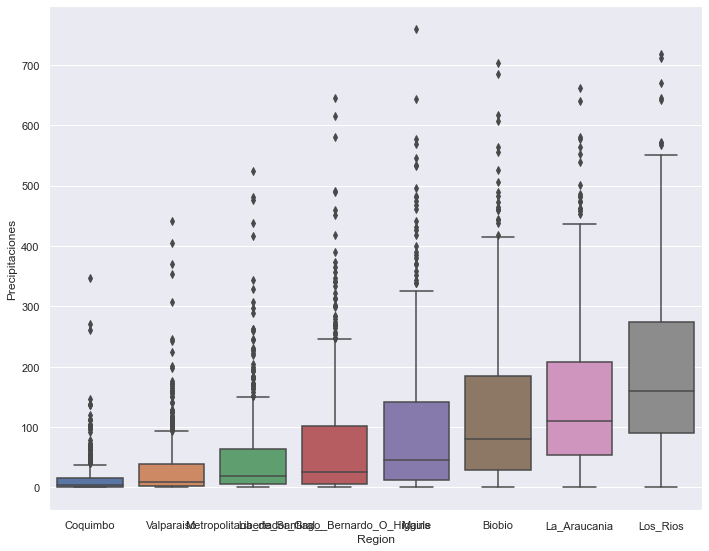

In [7]:
sns.set(rc={'figure.figsize':(11.7,9.27)})
sns.boxplot(x="Region", y="Precipitaciones", data=pd.melt(precip.iloc[:,1:], var_name='Region',  value_name='Precipitaciones'))


In [8]:
#Asimetría
precip.skew(axis=0)

Coquimbo                               4.969772
Valparaiso                             3.418567
Metropolitana_de_Santiago              2.861951
Libertador_Gral__Bernardo_O_Higgins    2.280482
Maule                                  1.908906
Biobio                                 1.488732
La_Araucania                           1.236218
Los_Rios                               1.007051
dtype: float64

In [9]:
#Curtosis
precip.kurt(axis=0)

Coquimbo                               35.857870
Valparaiso                             16.157271
Metropolitana_de_Santiago              10.799591
Libertador_Gral__Bernardo_O_Higgins     6.443054
Maule                                   4.086940
Biobio                                  2.141751
La_Araucania                            1.248657
Los_Rios                                0.612487
dtype: float64

Tanto el gráfico como la curtosis y la asimetría muestran la presencia de outliers, especialmente en la región de Coquimbo.

Sin embargo, investigando en sitios que manejan datos históricos de precipitaciones en chile como meteored.cl o la Base Digital del Clima del Ministerio del Medio Ambiente (http://basedigitaldelclima.mma.gob.cl/), se puede observar que esos valores extremos corresponden a casos reales de precipitaciones, por lo tanto no deben ser eliminados del dataset.

Tambien se puede ver que el dataset no contiene filas repetidas:

In [10]:
duplicatePrecip = precip[precip.duplicated()]
duplicatePrecip

,date,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios


Por lo que solo basta con transformas la fecha a tipo datetime, dejarla como index, y ordenar las filas:

In [11]:
precip['date'] = pd.to_datetime(precip['date'])
precip = precip.sort_values('date')
precip = precip.set_index(['date'])


También se agregará una columna de mes y año para facilitar el trabajo en los siguientes puntos.

In [12]:
precip['mes'] = pd.to_datetime(precip.index).month
precip['año'] = pd.to_datetime(precip.index).year

### 2.2 Variables económicas

In [13]:
banco.head()

,Periodo,Imacec_empalmado,Imacec_produccion_de_bienes,Imacec_minero,Imacec_industria,Imacec_resto_de_bienes,Imacec_comercio,Imacec_servicios,Imacec_a_costo_de_factores,Imacec_no_minero,...,Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100,Indice_de_produccion_industrial,Indice_de_produccion_industrial__mineria,Indice_de_produccion_industrial_electricidad__gas_y_agua,Indice_de_produccion_industrial__manufacturera,Generacion_de_energia_electrica_CDEC_GWh,Indice_de_ventas_comercio_real_IVCM,Indice_de_ventas_comercio_real_no_durables_IVCM,Indice_de_ventas_comercio_real_durables_IVCM,Ventas_autos_nuevos
0,2013-03-01 00:00:00 UTC,102.796.218,10.546.824,978.554.365,102.297.537,114.994.919,110.729.395,100.064.328,103.163.651,103.405.852,...,865.903.468,102.761.705,98.915.705,NaN,108.387.837,580.480.672,NaN,NaN,NaN,28577.0
1,2013-04-01 00:00:00 UTC,101.664.842,999.272.757,927.333.293,104.485.589,102.199.311,106.098.291,102.600.107,101.937.319,102.766.884,...,867.806.065,968.087.179,914.276.663,NaN,104.545.429,544.815.032,NaN,NaN,NaN,32206.0
2,2013-05-01 00:00:00 UTC,101.642.954,993.959.922,96.133.164,105.445.361,968.789.055,100.462.117,104.083.216,101.953.299,102.322.796,...,878.030.947,978.471.874,966.913.278,NaN,99.468.801,56.891.916,NaN,NaN,NaN,31589.0
3,2013-06-01 00:00:00 UTC,998.310.201,968.367.884,102.400.933,999.212.106,89.190.493,939.504.414,103.857.161,100.222.381,995.139.235,...,913.180.348,966.647.135,981.820.974,NaN,94.969.678,56.594.867,NaN,NaN,NaN,28457.0
4,2013-07-01 00:00:00 UTC,964.696.194,961.051.418,980.029.022,100.882.112,901.785.886,92.776.599,969.309.272,962.069.134,962.804.305,...,909.263.447,100.100.749,990.198.382,NaN,102.128.977,586.329.899,NaN,NaN,NaN,31736.0


In [14]:
banco.shape

(614, 85)

In [15]:
pd.set_option('display.max_rows', None)
banco.dtypes

Periodo                                                                                object
Imacec_empalmado                                                                       object
Imacec_produccion_de_bienes                                                            object
Imacec_minero                                                                          object
Imacec_industria                                                                       object
Imacec_resto_de_bienes                                                                 object
Imacec_comercio                                                                        object
Imacec_servicios                                                                       object
Imacec_a_costo_de_factores                                                             object
Imacec_no_minero                                                                       object
PIB_Agropecuario_silvicola                                  

Éste dataset se encuentra en peor estado que el anterior. A primera vista se ve que tiene muchos valores faltantes, pero al ordenarlos por fecha se ve que ocurre porque algunas variables comienzan a ser registradas desde una fecha en específico, por ejemplo, hay registros del Imacec solo desde 1996 en adelante, y del PIB desde el 2013.

Aparte de los datos faltantes, se puede observar que la mayoría de los datos estan guardados como 'object' y con puntos entre los numeros, lo que dificulta la transformacíon de éstos a 'float'. También, en algunas columnas como 'Precio_del_cobre_refinado_BML_dolareslibra', se ve un cambio de escala en los valores, lo que va a generar outliers si no se ajustan.

Se dejarán los valores en cada columna en una escala similar, sin tomar en cuenta la forma que tenga el valor real dado que al momento de la creación del modelo en el punto final, todos éstos serán normalizados.

#### 2.2.1 Problemas en el dataset
A continuación se trabajará en los problemas encontrados en el dataset:

##### 2.2.1.1 Fecha incorrecta

En una de las filas, se encuentra una fecha que hace referencia a un mes 13,  lo que genera errores al momento de convertir esta columna al tipo que corresponde.

In [16]:
banco["Periodo"] = banco["Periodo"].str.replace(r"(?<=-)(13)(?=-)", "12")
banco['Periodo'] = pd.to_datetime(banco['Periodo'])


##### 2.2.1.2 Fila repetida
Existen 2 filas en el dataset que se repiten una vez cada una. Se buscarán y eliminarán las copias.

In [17]:
banco.drop_duplicates(keep='first',inplace=True)

##### 2.2.1.3 Puntos en números
Los números que están guardados como 'object' tienen puntos entre medio que no permiten la conversión a 'float'. Se buscaran estos puntos con expresiones regulares y serán eliminados.

In [18]:
banco = banco.replace(to_replace=r'(?<=[0-9])(\.)(?=[0-9])', value='', regex=True)


##### 2.2.1.4 'a' en valores faltantes
Otro elemento que no permite la tranformación de los valores a tipo 'float' es la existencia de casillas que tienen el valor 'a' en vez de NaN. Se buscarán y se reemplazarán por el valor correspondiente, para finalmente poder transformar el dataset a 'float'.

In [19]:
banco = banco.replace(to_replace=r'a', value=np.nan)
banco.iloc[:,1:] = banco.iloc[:,1:].astype(str).astype(float)

#### 2.2.2 Selección de variables
Para simplificar el trabajo (por temas de tiempo), de este dataset se tomarán en cuenta solo las columnas relacionadas al Imacec y al PIB y a las que representan precios, ya que deberían representar de mejor manera la actividad economica del país. Sin embargo, mas adelante se hará una selección de las mejores variables para el modelo.

In [20]:
columnas = [c for c in banco.columns if ("Periodo" in c) or ("Imacec" in c) or ("PIB" in c) or ("Precio" in c)]
columnas

['Periodo',
 'Imacec_empalmado',
 'Imacec_produccion_de_bienes',
 'Imacec_minero',
 'Imacec_industria',
 'Imacec_resto_de_bienes',
 'Imacec_comercio',
 'Imacec_servicios',
 'Imacec_a_costo_de_factores',
 'Imacec_no_minero',
 'PIB_Agropecuario_silvicola',
 'PIB_Pesca',
 'PIB_Mineria',
 'PIB_Mineria_del_cobre',
 'PIB_Otras_actividades_mineras',
 'PIB_Industria_Manufacturera',
 'PIB_Alimentos',
 'PIB_Bebidas_y_tabaco',
 'PIB_Textil',
 'PIB_Maderas_y_muebles',
 'PIB_Celulosa',
 'PIB_Refinacion_de_petroleo',
 'PIB_Quimica',
 'PIB_Minerales_no_metalicos_y_metalica_basica',
 'PIB_Productos_metalicos',
 'PIB_Electricidad',
 'PIB_Construccion',
 'PIB_Comercio',
 'PIB_Restaurantes_y_hoteles',
 'PIB_Transporte',
 'PIB_Comunicaciones',
 'PIB_Servicios_financieros',
 'PIB_Servicios_empresariales',
 'PIB_Servicios_de_vivienda',
 'PIB_Servicios_personales',
 'PIB_Administracion_publica',
 'PIB_a_costo_de_factores',
 'PIB',
 'Precio_de_la_gasolina_en_EEUU_dolaresm3',
 'Precio_de_la_onza_troy_de_oro_do

<AxesSubplot:>

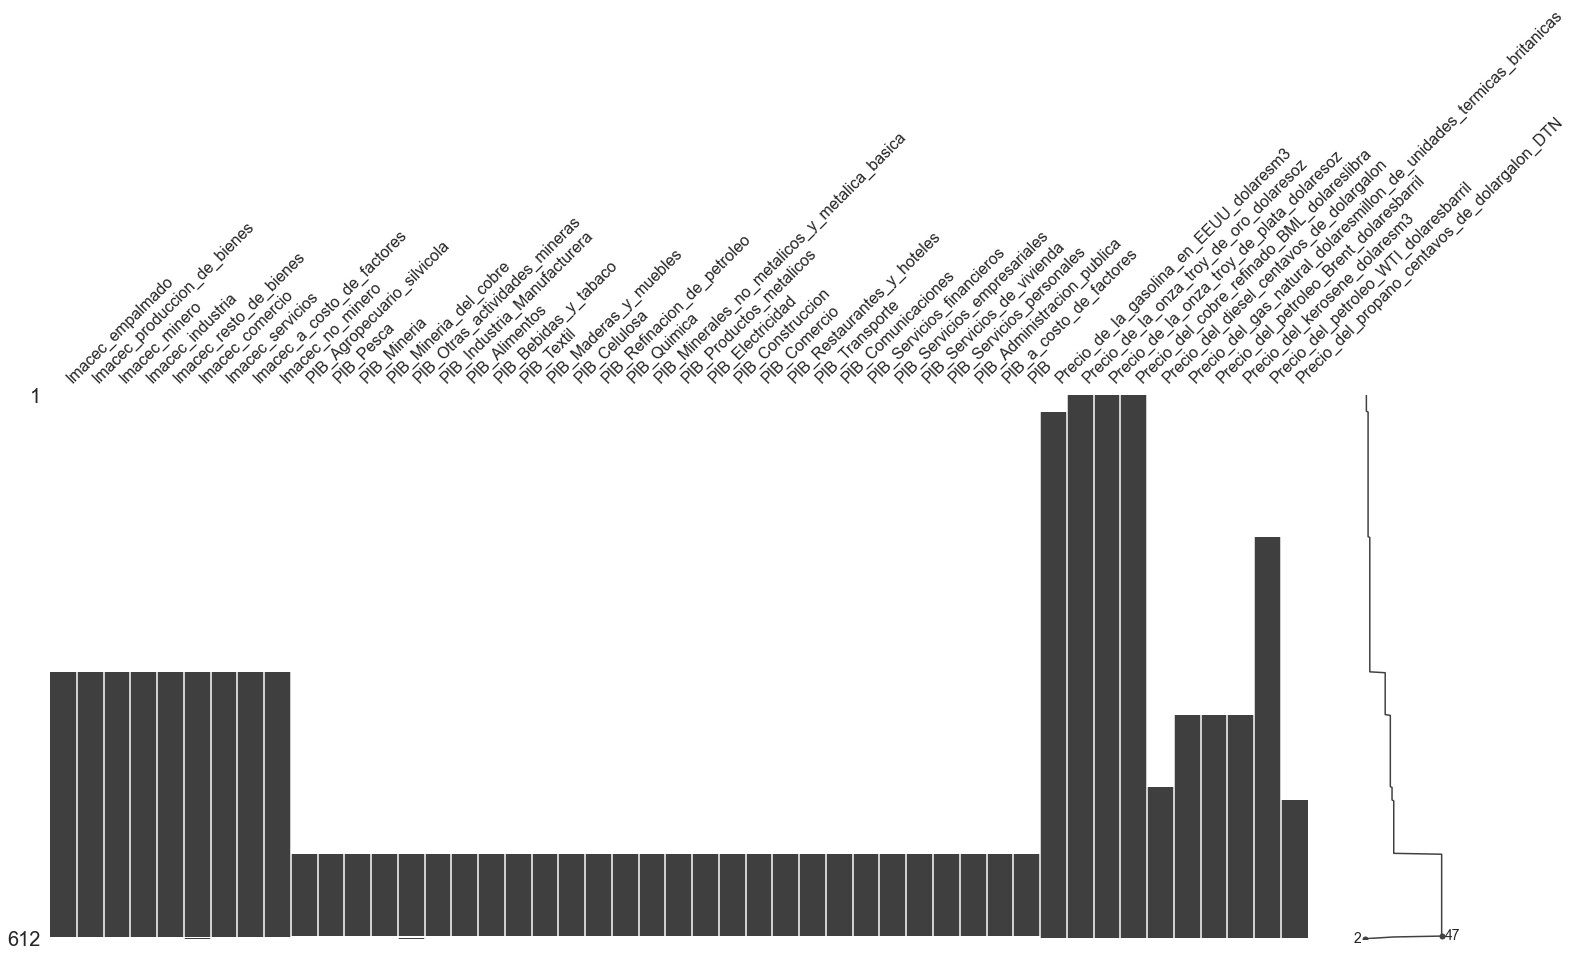

In [21]:
banco_temp = banco[columnas] 
banco_temp = banco_temp.sort_values('Periodo')
banco_temp['Periodo'] = banco_temp['Periodo'].dt.tz_convert(None)
banco_temp = banco_temp.set_index(['Periodo'])
msno.matrix(banco_temp)


Para el manejo de los outliers se encontrarán y eliminarán con ayuda del rango intercuartílico y luego se interpolaran los valores.

In [22]:
banco_final =  copy.copy(banco_temp)
for col in banco_temp:
    Q1 = banco_temp[col].quantile(0.25)
    Q3 = banco_temp[col].quantile(0.75)
    IQR = Q3 - Q1
    banco_final[col][banco_final[col]<(Q1 - 1.5 * IQR)]=np.nan

banco_final = banco_final.interpolate(method='linear')

## 3. Visualización
### 3.1 Precipitaciones para un rango de fechas

In [23]:
def precip_rango(region, inicio, fin):
    if region in precip.columns and precip.loc[inicio].any() and precip.loc[fin].any():
        precipgraf = precip.loc[inicio:fin]
        sns.set(rc={'figure.figsize':(11.7,8.27)})
        g = sns.relplot(x="date", y=region, kind="line", data=precipgraf)
        g.set_xticklabels(rotation=60)
    else:
        print('No se encontraron los valores en el dataset')

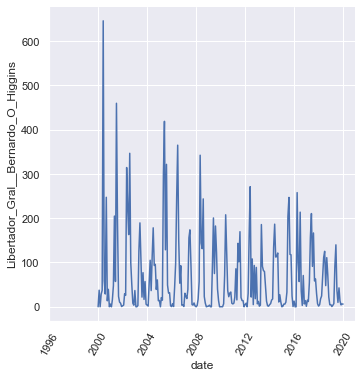

In [24]:
precip_rango('Libertador_Gral__Bernardo_O_Higgins', '2000-01-01','2020-01-01')

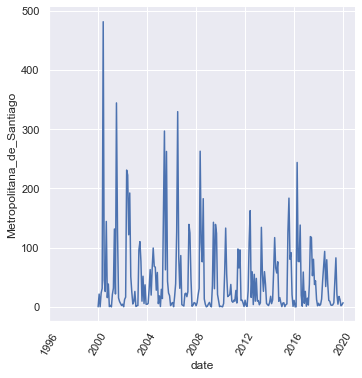

In [25]:
precip_rango('Metropolitana_de_Santiago', '2000-01-01','2020-01-01')

Se puede ver una estacionalidad anual en estas series de tiempo, pero igual siguen una tendencia. En éste caso, en los últimos 20 años van disminuyen las precipitaciones en las regiones durante los meses de invierno. Hoy en día los valores extremos de precipitaciones son casi 4 veces menores que los que se veían a principios del siglo.

También se aprecia que los valores entre las 2 regiones, al ser cercanas, son similares, lo que va acorde a lo esperado.

### 3.2 Precipitaciones mensuales

In [26]:
def precip_mensual(años, region):
    precipgraf = precip.loc[precip['año'].isin(años)]
    sns.lineplot(x='mes',y=region,hue='año',data=precipgraf)
    

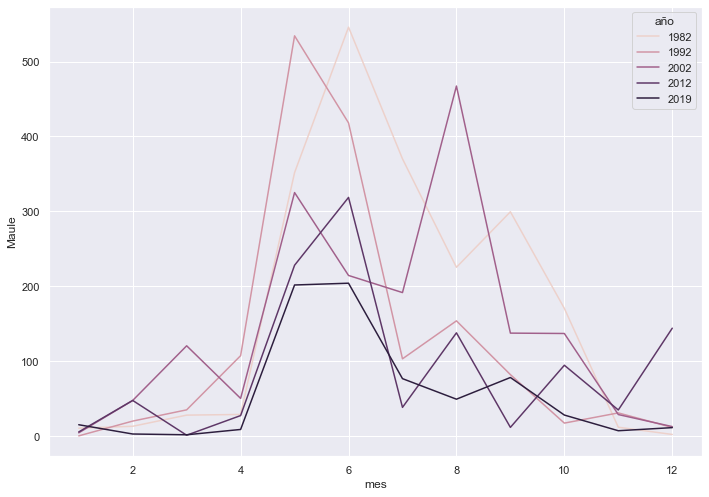

In [27]:
precip_mensual(['1982', '1992', '2002', '2012' , '2019'], 'Maule')

Al igual que en los graficos anteriores se observa una disminución en la precipitaciones aun cuando se trata de regiones al sur de Chile. Las máximas en el año 2019 son menos de la mitad de lo que fueron hace 4 decadas.

Es interesante tambien ver como en el último tiempo se presentan lluvias fuera de los meses de invierno, especialmente a fines del 2012.

### 3.3 PIB por fecha

In [28]:
def pib(series,inicio,fin):
    pibgraf = banco_final[series].loc[inicio:fin]
    pibgraf.plot()
    plt.xlabel("Fecha")

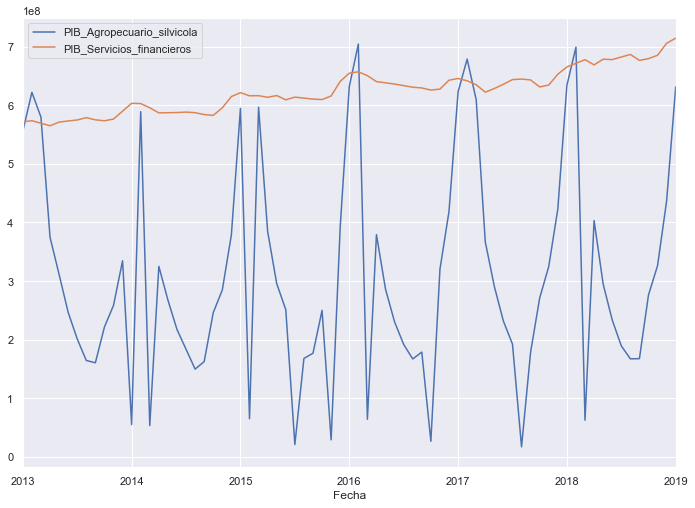

In [29]:
pib(['PIB_Agropecuario_silvicola','PIB_Servicios_financieros'],'2013-01-01','2019-01-01')

Se ve que el PIB Financiero ha ido creciendo a lo largo de los años, mientras que el PIB Agropecuario y silvicola tiene sus mayores valores en los meses de verano, lo que calzaría con las fechas de cosechas de frutas y verduras. 

Se puede notar que los momentos peak del PIB AyS corresponden a pequeños aumentos en el PIB Financiero, que suben y bajan juntos en distintas escalas.  

## 4. Tratamiento y creación de variables

En primer lugar se cargará el dataset de precios de leche. 

In [30]:
leche = pd.read_csv("precio_leche.csv")
leche.head(12)

,Anio,Mes,Precio_leche
0,1979,Ene,3.85
1,1979,Feb,4.58
2,1979,Mar,5.18
3,1979,Abr,6.06
4,1979,May,7.25
5,1979,Jun,7.71
6,1979,Jul,8.10
7,1979,Ago,7.65
8,1979,Sep,6.96
9,1979,Oct,5.79


Para poder crear una columna de fecha y poder hacer merge con los otros datasets, se debe reemplazar el nombre de la columna 'Mes' por sus valores numéricos.

In [31]:
leche['Mes'] = leche['Mes'].replace(["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"], ["01", "02", "03" , "04", "05", "06", "07", "08", "09", "10", "11", "12"])
leche.head(12)


,Anio,Mes,Precio_leche
0,1979,01,3.85
1,1979,02,4.58
2,1979,03,5.18
3,1979,04,6.06
4,1979,05,7.25
5,1979,06,7.71
6,1979,07,8.10
7,1979,08,7.65
8,1979,09,6.96
9,1979,10,5.79


También debe agregarse una columna 'Dia' para poder crear la columna 'date' en el formato correcto.

In [32]:
leche['Dia'] = "01"
leche['Mes'] = leche['Mes'].astype(str).astype(float)
leche['Dia'] = leche['Dia'].astype(str).astype(float)

Precio_leche           float64
date            datetime64[ns]
dtype: object


<AxesSubplot:>

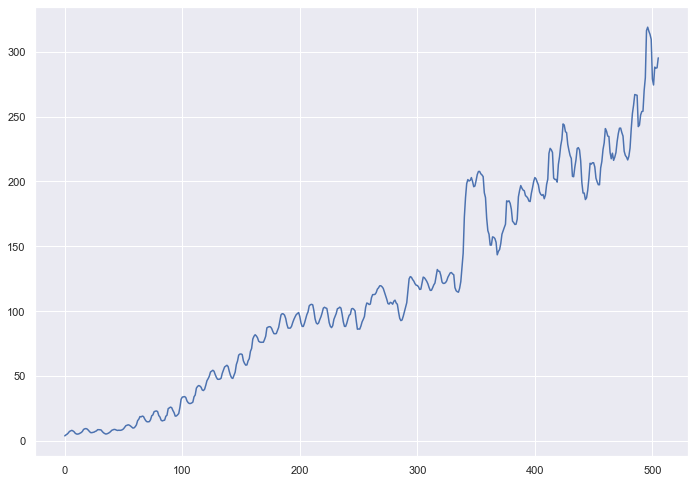

In [33]:
leche['date'] = pd.to_datetime((leche.Anio*10000+leche.Mes*100+ leche.Dia).apply(str),format='%Y%m%d')
leche = leche.drop(['Mes', 'Anio', 'Dia'], axis=1)
print(leche.dtypes)

leche['Precio_leche'].plot()

En primer lugar se hará un merge de los datasets de precios de leche con el de precipitaciones a través de la columna 'date', y luego con el dataset del banco con la columna 'Periodo'.

In [34]:
merge_df = pd.merge(precip, leche, on='date')
merge_df

,date,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios,mes,año,Precio_leche
0,1979-01-01,2.641948,0.587062,2.447114,1.608992,3.736215,17.859634,25.212940,45.596447,1,1979,3.85
1,1979-02-01,1.179804,2.432192,3.997852,4.346310,16.347637,17.680612,18.085072,34.075039,2,1979,4.58
2,1979-03-01,0.255490,0.020601,0.000000,0.055488,0.545324,14.435698,28.696504,66.232248,3,1979,5.18
3,1979-04-01,10.173699,11.745779,13.722349,12.989194,21.880607,39.136483,43.617921,73.548127,4,1979,6.06
4,1979-05-01,1.039098,18.609286,50.187148,104.451550,143.914334,219.729235,279.409718,438.005116,5,1979,7.25
5,1979-06-01,0.141157,0.000000,1.397164,7.378558,28.797945,72.501902,113.488705,179.949832,6,1979,7.71
6,1979-07-01,34.630791,118.340422,170.614262,301.256558,482.199009,411.270877,356.070480,424.988334,7,1979,8.10
7,1979-08-01,9.073373,49.270309,130.503624,200.210387,294.567554,378.102706,458.753077,645.763592,8,1979,7.65
8,1979-09-01,12.041765,33.970292,77.705101,156.477457,161.299858,158.965598,203.191759,252.733618,9,1979,6.96
9,1979-10-01,0.018634,0.558101,10.871275,14.557008,11.238902,51.010499,121.420487,177.008294,10,1979,5.79


In [35]:
df_final = pd.merge(merge_df, banco_final, left_on='date',right_on='Periodo',how='left')
df_final

,date,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios,mes,...,Precio_de_la_gasolina_en_EEUU_dolaresm3,Precio_de_la_onza_troy_de_oro_dolaresoz,Precio_de_la_onza_troy_de_plata_dolaresoz,Precio_del_cobre_refinado_BML_dolareslibra,Precio_del_diesel_centavos_de_dolargalon,Precio_del_gas_natural_dolaresmillon_de_unidades_termicas_britanicas,Precio_del_petroleo_Brent_dolaresbarril,Precio_del_kerosene_dolaresm3,Precio_del_petroleo_WTI_dolaresbarril,Precio_del_propano_centavos_de_dolargalon_DTN
0,1979-01-01,2.641948,0.587062,2.447114,1.608992,3.736215,17.859634,25.212940,45.596447,1,...,13672.0,227.27,6.2600,752.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1979-02-01,1.179804,2.432192,3.997852,4.346310,16.347637,17.680612,18.085072,34.075039,2,...,16713.0,245.67,7.4200,882.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1979-03-01,0.255490,0.020601,0.000000,0.055488,0.545324,14.435698,28.696504,66.232248,3,...,16671.0,242.05,7.4500,93.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1979-04-01,10.173699,11.745779,13.722349,12.989194,21.880607,39.136483,43.617921,73.548127,4,...,19831.0,239.16,7.4900,952.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1979-05-01,1.039098,18.609286,50.187148,104.451550,143.914334,219.729235,279.409718,438.005116,5,...,24933.0,257.61,8.3700,873.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1979-06-01,0.141157,0.000000,1.397164,7.378558,28.797945,72.501902,113.488705,179.949832,6,...,2982.0,279.07,8.5400,852.0,NaN,NaN,NaN,NaN,NaN,NaN
6,1979-07-01,34.630791,118.340422,170.614262,301.256558,482.199009,411.270877,356.070480,424.988334,7,...,22856.0,294.69,9.1400,822.0,NaN,NaN,NaN,NaN,NaN,NaN
7,1979-08-01,9.073373,49.270309,130.503624,200.210387,294.567554,378.102706,458.753077,645.763592,8,...,20676.0,300.81,9.3300,896.0,NaN,NaN,NaN,NaN,NaN,NaN
8,1979-09-01,12.041765,33.970292,77.705101,156.477457,161.299858,158.965598,203.191759,252.733618,9,...,23234.0,355.11,13.9600,952.0,NaN,NaN,NaN,NaN,NaN,NaN
9,1979-10-01,0.018634,0.558101,10.871275,14.557008,11.238902,51.010499,121.420487,177.008294,10,...,25643.0,391.66,16.7800,943.0,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
df_final.dtypes

date                                                                    datetime64[ns]
Coquimbo                                                                       float64
Valparaiso                                                                     float64
Metropolitana_de_Santiago                                                      float64
Libertador_Gral__Bernardo_O_Higgins                                            float64
Maule                                                                          float64
Biobio                                                                         float64
La_Araucania                                                                   float64
Los_Rios                                                                       float64
mes                                                                              int64
año                                                                              int64
Precio_leche                               

A continuación se crearán variables del precio de la leche correspondiente al mes anterior, 6 meses atrás, y 1 año atrás, y también los promedios de precios del ultimo año y del ultimo trimestre.

In [37]:
df_final['precio_t-1'] = df_final['Precio_leche'].shift(1)
df_final['precio_t-6'] = df_final['Precio_leche'].shift(6)
df_final['precio_t-12'] = df_final['Precio_leche'].shift(12)
df_final['media_trimestre'] = df_final['Precio_leche'].rolling(window = 3).mean()
df_final['media_año'] = df_final['Precio_leche'].rolling(window = 12).mean()
df_final.dtypes


date                                                                    datetime64[ns]
Coquimbo                                                                       float64
Valparaiso                                                                     float64
Metropolitana_de_Santiago                                                      float64
Libertador_Gral__Bernardo_O_Higgins                                            float64
Maule                                                                          float64
Biobio                                                                         float64
La_Araucania                                                                   float64
Los_Rios                                                                       float64
mes                                                                              int64
año                                                                              int64
Precio_leche                               

In [38]:
df_final

,date,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios,mes,...,Precio_del_gas_natural_dolaresmillon_de_unidades_termicas_britanicas,Precio_del_petroleo_Brent_dolaresbarril,Precio_del_kerosene_dolaresm3,Precio_del_petroleo_WTI_dolaresbarril,Precio_del_propano_centavos_de_dolargalon_DTN,precio_t-1,precio_t-6,precio_t-12,media_trimestre,media_año
0,1979-01-01,2.641948,0.587062,2.447114,1.608992,3.736215,17.859634,25.212940,45.596447,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1979-02-01,1.179804,2.432192,3.997852,4.346310,16.347637,17.680612,18.085072,34.075039,2,...,NaN,NaN,NaN,NaN,NaN,3.85,NaN,NaN,NaN,NaN
2,1979-03-01,0.255490,0.020601,0.000000,0.055488,0.545324,14.435698,28.696504,66.232248,3,...,NaN,NaN,NaN,NaN,NaN,4.58,NaN,NaN,4.536667,NaN
3,1979-04-01,10.173699,11.745779,13.722349,12.989194,21.880607,39.136483,43.617921,73.548127,4,...,NaN,NaN,NaN,NaN,NaN,5.18,NaN,NaN,5.273333,NaN
4,1979-05-01,1.039098,18.609286,50.187148,104.451550,143.914334,219.729235,279.409718,438.005116,5,...,NaN,NaN,NaN,NaN,NaN,6.06,NaN,NaN,6.163333,NaN
5,1979-06-01,0.141157,0.000000,1.397164,7.378558,28.797945,72.501902,113.488705,179.949832,6,...,NaN,NaN,NaN,NaN,NaN,7.25,NaN,NaN,7.006667,NaN
6,1979-07-01,34.630791,118.340422,170.614262,301.256558,482.199009,411.270877,356.070480,424.988334,7,...,NaN,NaN,NaN,NaN,NaN,7.71,3.85,NaN,7.686667,NaN
7,1979-08-01,9.073373,49.270309,130.503624,200.210387,294.567554,378.102706,458.753077,645.763592,8,...,NaN,NaN,NaN,NaN,NaN,8.10,4.58,NaN,7.820000,NaN
8,1979-09-01,12.041765,33.970292,77.705101,156.477457,161.299858,158.965598,203.191759,252.733618,9,...,NaN,NaN,NaN,NaN,NaN,7.65,5.18,NaN,7.570000,NaN
9,1979-10-01,0.018634,0.558101,10.871275,14.557008,11.238902,51.010499,121.420487,177.008294,10,...,NaN,NaN,NaN,NaN,NaN,6.96,6.06,NaN,6.800000,NaN


Para seleccionar las variables correctas para el modelo se utilizará la correlación. Mientras mayor sea la correlación con la variable del precio de la leche, mejor será para el modelo.

In [39]:
correlacion = df_final.corr()['Precio_leche']
correlacion

Coquimbo                                                               -0.054579
Valparaiso                                                             -0.075917
Metropolitana_de_Santiago                                              -0.090931
Libertador_Gral__Bernardo_O_Higgins                                    -0.082729
Maule                                                                  -0.069165
Biobio                                                                 -0.045984
La_Araucania                                                           -0.022855
Los_Rios                                                               -0.001606
mes                                                                    -0.003768
año                                                                     0.975805
Precio_leche                                                            1.000000
Imacec_empalmado                                                       -0.292991
Imacec_produccion_de_bienes 

In [40]:
correlacion = correlacion.abs()
correlacion_sort = correlacion.sort_values()
correlacion_sort

Los_Rios                                                                0.001606
mes                                                                     0.003768
PIB_Otras_actividades_mineras                                           0.004956
Imacec_comercio                                                         0.005061
PIB_Pesca                                                               0.017242
PIB_Restaurantes_y_hoteles                                              0.020006
La_Araucania                                                            0.022855
PIB_Mineria                                                             0.029933
PIB_Maderas_y_muebles                                                   0.032402
Precio_del_diesel_centavos_de_dolargalon                                0.038088
PIB_Comercio                                                            0.043123
PIB_Agropecuario_silvicola                                              0.044212
Biobio                      

De éstas columnas se tomarán solo las que tengan una correlación superior a 0.4 y se creará con estas el dataset final para el modelo.

In [41]:
var = ['date']
for columna in correlacion_sort.index:
    if correlacion_sort[columna] >= 0.4:
        var.append(columna)
df_modelo = df_final[var]
df_modelo = df_modelo.set_index(['date'])
df_modelo.dtypes

PIB_Alimentos                                 float64
PIB_Textil                                    float64
PIB_Servicios_de_vivienda                     float64
PIB_Administracion_publica                    float64
Precio_del_petroleo_Brent_dolaresbarril       float64
PIB_Servicios_financieros                     float64
Precio_de_la_gasolina_en_EEUU_dolaresm3       float64
Precio_de_la_onza_troy_de_plata_dolaresoz     float64
Precio_del_petroleo_WTI_dolaresbarril         float64
Precio_del_cobre_refinado_BML_dolareslibra    float64
Precio_de_la_onza_troy_de_oro_dolaresoz       float64
precio_t-12                                   float64
año                                             int64
precio_t-6                                    float64
media_año                                     float64
precio_t-1                                    float64
media_trimestre                               float64
Precio_leche                                  float64
dtype: object

## 5. Modelo

Para la predicción del precio de la leche se usara XGBoost. 

Se tomarán los datos desde 1979-12-01 ya que desde esa fecha empiezan a aparecer todas las variables derivadas del precio que se agregaron.

In [43]:
df_modelo = df_modelo.loc['1979-12-01':]

Se dividen los datos para separar la columna que se quiere predecir.

In [44]:
X = df_modelo.iloc[:,df_modelo.columns != 'Precio_leche']
y = df_modelo['Precio_leche']


Luego se separa en test y train. Se usará un tamaño de test standard de 25% y se realiza la predicción con XGBoost

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
xg_reg = xgb.XGBRegressor(objective='reg:squarederror')
xg_reg.fit(X_train,y_train, eval_metric="rmse")
prediccion = xg_reg.predict(X)
prediccion_df = pd.DataFrame(prediccion, index = X.index)

C:\Users\David\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Se calcula el valor cuadrático medio como una forma de medir el desempeño del modelo.

In [53]:
rmse = np.sqrt(mean_squared_error(y, prediccion))
print("RMSE: %f" % (rmse))

RMSE: 3.399617


Para ver graficamente la diferencia entre lo real y lo predicho, se graficarán ambas series.

In [47]:
prediccion_df=prediccion_df.merge(y,on='date')

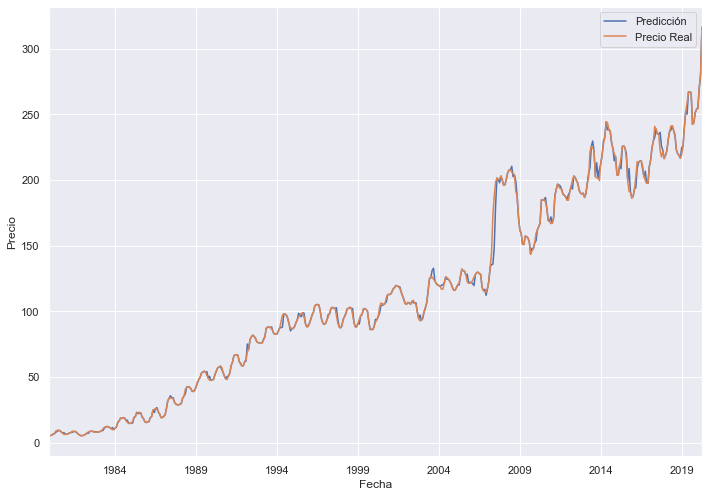

In [48]:
prediccion_df.columns=["Predicción","Precio Real"]
prediccion_df.plot()
plt.ylabel("Precio")
plt.xlabel("Fecha")
plt.show()


### ¿Qué datos adicionales te gustaría tener?¿Qué datos son necesarios para que este modelo funcione/mejore las métricas?

Hubiera sido útil tener datos económicos mas consistentes y no solo sobre Chile. Me imagino que la producción no se ve afectada solamente por elementos locales. 

También hubiera sido útil tener información sobre el consumo/demanda de leche en el país y sobre los costos de producción, almacenamiento, traslado, etc.

###  ¿Cómo evalúas el resultado del modelo?¿Qué métricas tiene sentido mirar?
Si bien podrian hacerse muchas mejoras al modelo, y sacarse muchas otras métricas, se dejará hasta aca con un RMSE de 3.399617 por temas de tiempo. Sklearn ofrece herramientas para obtener otras métricas como MSE y MAE que servirían para evaluar el modelo.

También sería bueno para mejorar el desempeño un estudio mas exhaustivo de las variables utilizadas para entrenar y de los parámetros que pueden utilizarse en XGBoost.

###   ¿Para qué aplicaciones puede servir un modelo de este tipo? En particular, ¿Cómo podría ayudar a combatir el cambio climático?

Solo mirando los datos de precipitaciones es posible ver como va cambiando el comportamiento de la lluvia en el país, como cada vez va disminuyendo incluso en regiones mas al sur. Un modelo como éste podria predecir como éstos valores de precipitaciones (o de otras mediciones, como la concentración de CO2 o la temperatura) probablemente seguirán cambiando y ayudaría a distinguir los factores que influyen en esto (como por ejemplo los gases de inverdadero producidos por la industria ganadera). 
